In [55]:
from random import choice
import numpy as np
from decimal import Decimal
import pandas as pd

# Solução Genética de uma Função

**Problema**

Implemente um algoritmo genético que busca maximizar a seguinte equação:

$$f(𝑥,𝑦)=−𝑥^2−𝑦^2+6𝑥+4𝑦$$

A solução ótima ocorre em 𝑥=3 e 𝑦=2. Ao substituir as variáveis 𝑥 e 𝑦 na equação pelos valores indicados, obtemos o resultado 𝑓(3,2)=13.

Requisitos da implementação:
* *Representação dos indivíduos*: Cada indivíduo da população deve representar um par de valores (𝑥,𝑦). 
* *Operadores*: O grupo deve escolher e implementar os operadores de seleção, cruzamento e mutação que serão usados pelo seu algoritmo genético. 
* Saída: O programa deve apresentar, para cada geração, qual é o melhor indivíduo e o valor da sua aptidão. Ao final da execução do algoritmo, o programa deve apresentar o resultado obtido para 𝑥 e 𝑦.

## Execução

A própria função matemática que se deseja otimizar funciona como medida de aptidão: quanto maior o valor de $f(x,y)$ de uma solução candidata, mais apta ela está de encontrar o maior resultado possível.

In [56]:
def função(x,y):
    x, y = Decimal(x), Decimal(y)
    return - x**2 - y**2 + 6*x + 4*y

Passos:
* Cria $P$ pais
* --- Primeira geração ---
* Cria $F$ filhos para cada pai
* Os filhos têm seus valores X e Y mudados a partir de seus pais ($TaxaMutação$ e $EscalaMutação$)
* Mede a aptidão dos filhos
* Inclui os pais e os filhos no grupo de teste
* Filtra os $P$ melhores candidatos
* Decide se encerra os ciclos pelo máximo de gerações ou quando um candidato atinge a aptidão máxima.
* --- Próxima geração

**Mutações**  
São valores aleatórios somados ou subtraídos do pai para o filho.  
Esses valores variam de $-TxM$ a $+TxM$, fragmentado em $EsM$.  
Cada pai gera $F$ filhos, que herdam suas características e sofrem mutações.  
Nenhum filho terá as exatas mesmas características de seus pais, nem de seus irmãos.  

In [57]:
# Classe de soluções candidatas

class Candidato:
    def __init__(self):
        self.x = 0
        self.y = 0
        self.f = 0.0

    # O método de mutação é responsável por alterar as características do Candidato
    #  com base em seu pai recebendo valores fixos,
    #  aleatorizados na função de reprodução
    def mutação(self, pai, mutação_x, mutação_y):
        '''Faz que o filho herde o valor do pai e aplique a mutação.
        A mutação é feita com base na taxa de mutação e na escala de mutação.'''
        self.x = pai.x + mutação_x
        self.y = pai.y + mutação_y
        self.f = função(self.x, self.y)

In [58]:
def reprodução(pai,n_filhos,taxa_mutação,escala_mutação):
    mutações = []
    # O loop a seguir garante que não haja mutações repetidas
    while len(mutações) < n_filhos:
        alcance = np.arange(-taxa_mutação, +taxa_mutação, escala_mutação)
        alteração = (choice(alcance), choice(alcance))
        if alteração not in mutações and alteração != (0,0):
            mutações.append(alteração)
    ninho = [Candidato() for _ in range(n_filhos)]
    for i in range(n_filhos):
        # Aplicando a mutação
        ninho[i].mutação(pai, mutações[i][0], mutações[i][1])
    # O resultado é o uma lista de filhos
    return ninho

In [59]:
def filtro(bando, n_pais):
    '''Filtra os filhos, mantendo apenas os n_pais com maior valor de aptidão.'''
    bando.sort(key=lambda x: x.f, reverse=True)
    return bando[:n_pais]

In [60]:
def primeira_geração(n_pais,taxa_mutação,escala_mutação):
    '''Gera a primeira geração com o número de pais.'''
    return reprodução(Candidato(),n_pais,taxa_mutação,escala_mutação)

In [61]:
def demonstração(bando,geração,max_aptidão, n_exibidos=1):
    '''Exibe os melhores indivíduos da geração.'''
    es = 'es' if n_exibidos > 1 else ''
    s = 's' if n_exibidos > 1 else ''

    print(f'''
    Melhor{es} candidato{s} da {geração}ª geração:''')
    bando.sort(key=lambda x: x.f, reverse=True)
    for candidato in bando[:n_exibidos]:
        if candidato.f == max_aptidão:
            print(f'X: {candidato.x:.3f} Y: {candidato.y:.3f} F: {candidato.f:.20f} *')
        else:
            print(f'X: {candidato.x:.3f} Y: {candidato.y:.3f} F: {candidato.f:.20f} ')

A função de evolução é responsável por gerar ciclos reprodutivos e demonstrar os melhores candidatos.  
O ciclo é interrompido quando o número máximo de gerações é atingido ou quando o resultado da função é encontrado.

In [62]:
def evolução(
        n_filhos = 10, 
        n_pais = 1, 
        taxa_mutação = 1, 
        escala_mutação = 0.1, 
        max_gerações = 100, 
        max_aptidão = np.nan,
        verbose = True):
    '''Executa o algoritmo genético.
    O loop termina quando a geração máxima a aptidão máxima é atingida.'''
    # Tratamento de erros
    if taxa_mutação < escala_mutação*2:
        raise ValueError('A taxa de mutação deve menor ou igual ao dobro da escala de mutação.')
    if taxa_mutação <= 0:
        raise ValueError('A taxa de mutação deve ser maior que zero.')
    if escala_mutação <= 0:
        raise ValueError('A escala de mutação deve ser maior que zero.')
    ciclo = True
    pais  = primeira_geração(n_pais,taxa_mutação,escala_mutação)
    geração = 0
    if verbose:
        demonstração(pais,geração,max_aptidão)

    # Lista incluindo melhores resultados de cada geração
    # Esta lista será retornada para a entrada do gráfico posterior
    result = []

    while ciclo:
        geração +=1
        bando = []
        gen = pd.DataFrame(columns=['x', 'y', 'z'])
        # Gerando os filhos
        for pai in pais:
            bando += reprodução(pai,n_filhos,taxa_mutação,escala_mutação)
        bando += pais
        # Filtrando os candidatos
        pais = filtro(bando, n_pais)
        # Demonstração da geração:
        if verbose:
            demonstração(pais,geração,max_aptidão)
        if max_aptidão != np.nan:
            for indivíduo in pais:
                if indivíduo.f == max_aptidão:
                    ciclo = False
        
        for pai in pais:
            gen.loc[len(gen)] = {'x': pai.x, 'y': pai.y, 'z': pai.f}
        
        result.append(gen.astype(float)) #Alterando os resultados para float porque o matplotlib não sabe o que é decimal

        if geração == max_gerações:
            ciclo = False
    
    if not verbose:
        demonstração(pais,geração,max_aptidão)
    return result

In [63]:
def main():
    '''Função principal. Executa o algoritmo genético.'''
    # Parâmetros do algoritmo
    n_filhos = 16
    n_pais = 8
    taxa_mutação = 0.3
    escala_mutação = 0.1
    max_gerações = 100
    max_aptidão = 13.0
    # Executando o algoritmo genético
    return evolução(n_filhos, n_pais, taxa_mutação, escala_mutação, max_gerações, max_aptidão)

result = main()


    Melhor candidato da 0ª geração:
X: 0.100 Y: 0.200 F: 1.35000000000000023315 

    Melhor candidato da 1ª geração:
X: 0.300 Y: 0.400 F: 3.15000000000000031086 

    Melhor candidato da 2ª geração:
X: 0.500 Y: 0.600 F: 4.79000000000000024869 

    Melhor candidato da 3ª geração:
X: 0.700 Y: 0.700 F: 6.02000000000000025757 

    Melhor candidato da 4ª geração:
X: 0.800 Y: 0.900 F: 6.95000000000000048850 

    Melhor candidato da 5ª geração:
X: 1.000 Y: 1.100 F: 8.19000000000000015987 

    Melhor candidato da 6ª geração:
X: 1.200 Y: 1.200 F: 9.12000000000000012434 

    Melhor candidato da 7ª geração:
X: 1.400 Y: 1.400 F: 10.07999999999999987566 

    Melhor candidato da 8ª geração:
X: 1.600 Y: 1.500 F: 10.78999999999999962697 

    Melhor candidato da 9ª geração:
X: 1.800 Y: 1.600 F: 11.39999999999999982236 

    Melhor candidato da 10ª geração:
X: 2.000 Y: 1.700 F: 11.90999999999999966249 

    Melhor candidato da 11ª geração:
X: 2.200 Y: 1.900 F: 12.34999999999999960032 

    Melh

## Função desconhecida

In [64]:
# Considerei estranho os parâmetros nunca serem negativos, embora seja possível pela construção da função de reprodução
# então criei esta outra função para saber se o objetivo poderia ser alcansado, inclusive deconhecendo seu valor ótimo
def função(x,y):
    x, y = Decimal(x), Decimal(y)
    return - x**2 - y**2 + 6*x + 20*y

In [65]:
def main():
    '''Função principal. Executa o algoritmo genético.'''
    # Parâmetros do algoritmo
    n_filhos = 10
    n_pais = 5
    taxa_mutação = 1
    escala_mutação = 0.01
    max_gerações = 500
    max_aptidão = 13.0
    # Executando o algoritmo genético
    evolução(n_filhos, n_pais, taxa_mutação, escala_mutação, max_gerações, verbose=False)

main()


    Melhor candidato da 500ª geração:
X: 3.000 Y: 10.000 F: 109.00000000000000000000 


## Criação do gráfico 3D

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [67]:
def função(x,y):
    #x, y = Decimal(x), Decimal(y)
    return - x**2 - y**2 + 6*x + 4*y

In [68]:
x_min = min([gen['x'].min() for gen in result])
x_max = max([gen['x'].max() for gen in result])
y_min = min([gen['y'].min() for gen in result])
y_max = max([gen['y'].max() for gen in result])
central = max([gen['z'].max() for gen in result])

amp_x = max(abs(x_min),abs(x_max))
amp_y = max(abs(y_min),abs(y_max))

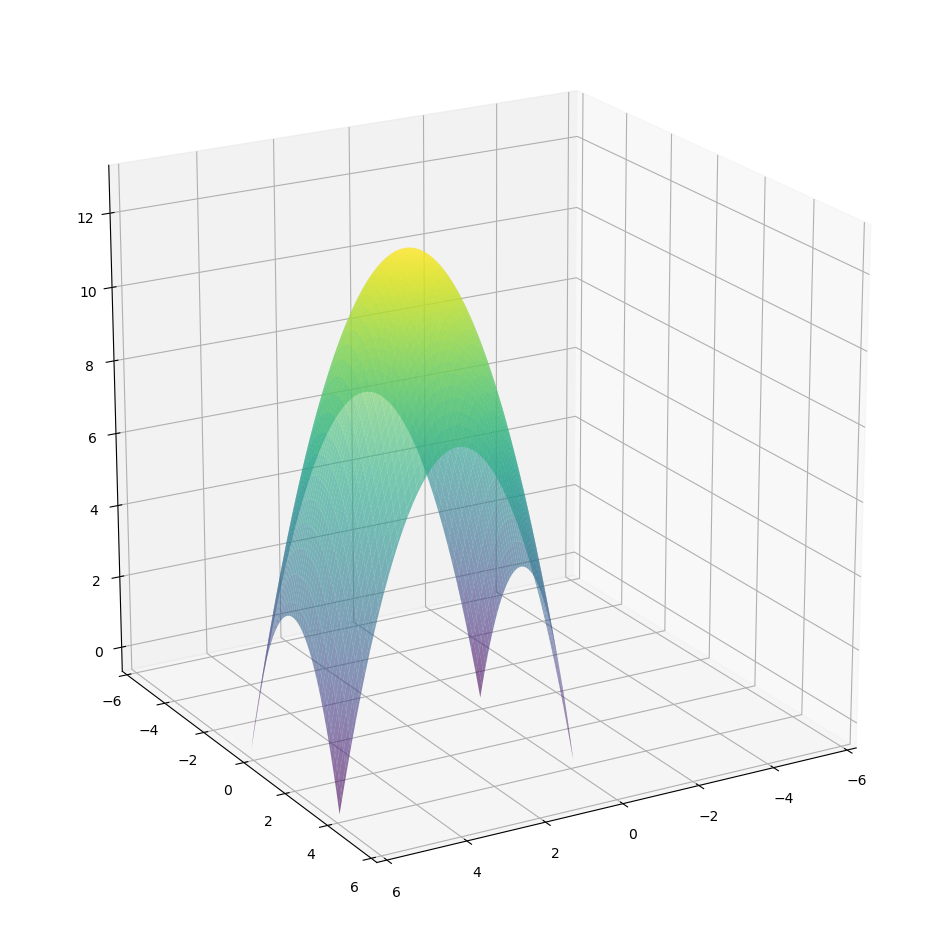

MovieWriter imagemagick unavailable; using Pillow instead.


In [69]:

# Melhor candidato em cada geração
melhores = [result['z'].astype(float).idxmax() for result in result]

# Superfície
x = np.linspace(3-amp_x, 3+amp_x, 100)
y = np.linspace(2-amp_y, 2+amp_y, 100)
X, Y = np.meshgrid(x, y)
Z = função(X, Y)

# Figura
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)

# Inicialização dos pontos
scatter = ax.scatter([], [], [], color='blue', s=30)
melhor, = ax.plot([], [], [], 'o', color='red', markersize=12)

ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(np.min(Z), np.max(Z))

# Função para animar os pontos
def update(frame):
    df = result[frame]
    xs = df['x'].values
    ys = df['y'].values
    zs = df['z'].values
    scatter._offsets3d = (xs, ys, zs)
    idx = melhores[frame]
    x_melhor = df.loc[idx, 'x']
    y_melhor = df.loc[idx, 'y']
    z_melhor = df.loc[idx, 'z']
    melhor.set_data([x_melhor], [y_melhor])
    melhor.set_3d_properties([z_melhor])
    ax.set_title(f'Geração {frame+1}')
    return scatter, melhor

ax.view_init(elev=20, azim=60)

anim = FuncAnimation(fig, update, frames=len(result), interval=500, blit=False)

ax.set_box_aspect([1,1,1])  # Proporção dos eixos
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()
anim.save('quadratic_function_3d.gif', writer='imagemagick', fps=2)
